**Author**: Leon  
**Date**: 2025-03-24

## 📌 Project Description
This notebook implements a simplified heads-up All-in or Fold (AOF) poker game simulation framework for evaluating and comparing poker strategies.  
The focus is on demonstrating how AIVAT (Action-Informed Value Assessment Tool) reduces variance in win-rate estimation, especially in small-sample scenarios.

### 🧪 The experiment includes:

- Building strategies and simulation engine   
- Long-term EV comparison between Strategy A and Strategy B   
- Measuring misjudgment rates under Raw EV vs AIVAT correction   
- Visualizing variance reduction effect   


### 🎯 Goal

The final goal is to illustrate that AIVAT can lead to more reliable strategy evaluation in noisy, high-variance environments.  



In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict

# Define hand strength (1 to 10, 10 is strongest)
hand_strengths = list(range(1, 11))

# Strategy A: Only goes all-in with hand >= 7
def strategy_a(hand_strength):
    return hand_strength >= 7

# Strategy B: Goes all-in with hand >= 5
def strategy_b(hand_strength):
    return hand_strength >= 5

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [2]:
# Simulate One Hand Logic
def simulate_one_hand():
    cards = random.sample(hand_strengths, 2)
    a_card, b_card = cards[0], cards[1]
    a_action = strategy_a(a_card)
    b_action = strategy_b(b_card)

    if a_action and b_action:
        if a_card > b_card:
            return 2, -2
        elif a_card < b_card:
            return -2, 2
        else:
            return 0, 0
    elif a_action and not b_action:
        return 1, -1
    elif not a_action and b_action:
        return -1, 1
    else:
        return 0, 0

In [3]:
# Simulate Large-Scale Raw EV Comparison
def simulate_long_term_ev(n=100000):
    a_total, b_total = 0, 0
    for _ in range(n):
        a_result, b_result = simulate_one_hand()
        a_total += a_result
        b_total += b_result

    return {
        "Total Hands": n,
        "A Total Profit": a_total,
        "B Total Profit": b_total,
        "A Avg Profit/Hand": round(a_total / n, 4),
        "B Avg Profit/Hand": round(b_total / n, 4)
    }

print("\nLong-Term Simulation Result")
print(simulate_long_term_ev())


Long-Term Simulation Result
{'Total Hands': 100000, 'A Total Profit': -2345, 'B Total Profit': 2345, 'A Avg Profit/Hand': -0.0234, 'B Avg Profit/Hand': 0.0234}


In [4]:
# Small Sample Misjudgment Rate with Raw EV
def simulate_raw_ev_misjudge_rate(n_hands_per_batch=100, num_batches=100):
    misjudge_count = 0
    batch_ev_list = []

    for _ in range(num_batches):
        a_total, b_total = 0, 0
        for _ in range(n_hands_per_batch):
            a_result, b_result = simulate_one_hand()
            a_total += a_result
            b_total += b_result
        if a_total > b_total:
            misjudge_count += 1

        batch_ev_list.append(a_total / n_hands_per_batch)

    misjudge_rate = round(misjudge_count / num_batches * 100, 2)
    variance = round(np.var(batch_ev_list), 6)

    return {
        "Batch Size": n_hands_per_batch,
        "Batches": num_batches,
        "Misjudgments (A > B)": misjudge_count,
        "Misjudgment Rate": f"{misjudge_rate}%"
    }, batch_ev_list

print("\nRaw EV Misjudgment Result")
raw_ev_result = simulate_raw_ev_misjudge_rate()
print(raw_ev_result[0])


Raw EV Misjudgment Result
{'Batch Size': 100, 'Batches': 100, 'Misjudgments (A > B)': 43, 'Misjudgment Rate': '43.0%'}


In [5]:
# Build Baseline Table for AIVAT
def compute_baseline_ev(strategy_opponent):
    baseline = {}
    for my_card in hand_strengths:
        evs = []
        for opp_card in hand_strengths:
            if opp_card == my_card:
                continue
            a_action = strategy_a(my_card)
            b_action = strategy_opponent(opp_card)
            if a_action and b_action:
                if my_card > opp_card:
                    result = 2
                elif my_card < opp_card:
                    result = -2
                else:
                    result = 0
            elif a_action and not b_action:
                result = 1
            elif not a_action and b_action:
                result = -1
            else:
                result = 0
            evs.append(result)
        baseline[my_card] = np.mean(evs)

    return baseline

baseline_table = compute_baseline_ev(strategy_b)
baseline_table

{1: np.float64(-0.6666666666666666),
 2: np.float64(-0.6666666666666666),
 3: np.float64(-0.6666666666666666),
 4: np.float64(-0.6666666666666666),
 5: np.float64(-0.5555555555555556),
 6: np.float64(-0.5555555555555556),
 7: np.float64(0.2222222222222222),
 8: np.float64(0.6666666666666666),
 9: np.float64(1.1111111111111112),
 10: np.float64(1.5555555555555556)}

In [6]:
# Simulate AIVAT EV Misjudgment Rate
def simulate_aivat_misjudge_rate(baseline, n_hands_per_batch=100, num_batches=100):
    misjudge_count = 0
    batch_ev_list = []

    for _ in range(num_batches):
        a_ev, b_ev = 0, 0
        for _ in range(n_hands_per_batch):
            cards = random.sample(hand_strengths, 2)
            a_card, b_card = cards[0], cards[1]
            a_action = strategy_a(a_card)
            b_action = strategy_b(b_card)
            if a_action and b_action:
                if a_card > b_card:
                    a_result = 2
                    b_result = -2
                elif a_card < b_card:
                    a_result = -2
                    b_result = 2
                else:
                    a_result = b_result = 0
            elif a_action and not b_action:
                a_result = 1
                b_result = -1
            elif not a_action and b_action:
                a_result = -1
                b_result = 1
            else:
                a_result = b_result = 0
            a_ev += a_result - baseline[a_card]
            b_ev += b_result - baseline[b_card]

        if a_ev > b_ev:
            misjudge_count += 1

        batch_ev_list.append(a_ev / n_hands_per_batch)

    misjudge_rate = round(misjudge_count / num_batches * 100, 2)
    variance = round(np.var(batch_ev_list), 6)

    return {
        "Batch Size": n_hands_per_batch,
        "Batches": num_batches,
        "Misjudgments (A > B)": misjudge_count,
        "Misjudgment Rate": f"{misjudge_rate}%"
    }, batch_ev_list

print("\nAIVAT Misjudgment Result")
aivat_result = simulate_aivat_misjudge_rate(baseline_table)
print(aivat_result[0])


AIVAT Misjudgment Result
{'Batch Size': 100, 'Batches': 100, 'Misjudgments (A > B)': 48, 'Misjudgment Rate': '48.0%'}


In [7]:
from scipy.stats import f

# F-test: H0 = equal variance
var_raw = np.var(raw_ev_result[1], ddof=1)
var_aivat = np.var(aivat_result[1], ddof=1)

# F-ratio (larger / smaller)
if var_raw > var_aivat:
    f_stat = var_raw / var_aivat
    dfn, dfd = len(raw_ev_result[1]) - 1, len(aivat_result[1]) - 1
else:
    f_stat = var_aivat / var_raw
    dfn, dfd = len(aivat_result[1]) - 1, len(raw_ev_result[1]) - 1

# p-value from F-distribution (two-tailed)
p_value = 2 * min(f.cdf(f_stat, dfn, dfd), 1 - f.cdf(f_stat, dfn, dfd))

{
    "Raw Variance": round(var_raw, 6),
    "AIVAT Variance": round(var_aivat, 6),
    "F-statistic": round(f_stat, 4),
    "p-value": round(p_value, 6)
}


{'Raw Variance': np.float64(0.018106),
 'AIVAT Variance': np.float64(0.007569),
 'F-statistic': np.float64(2.392),
 'p-value': np.float64(2e-05)}

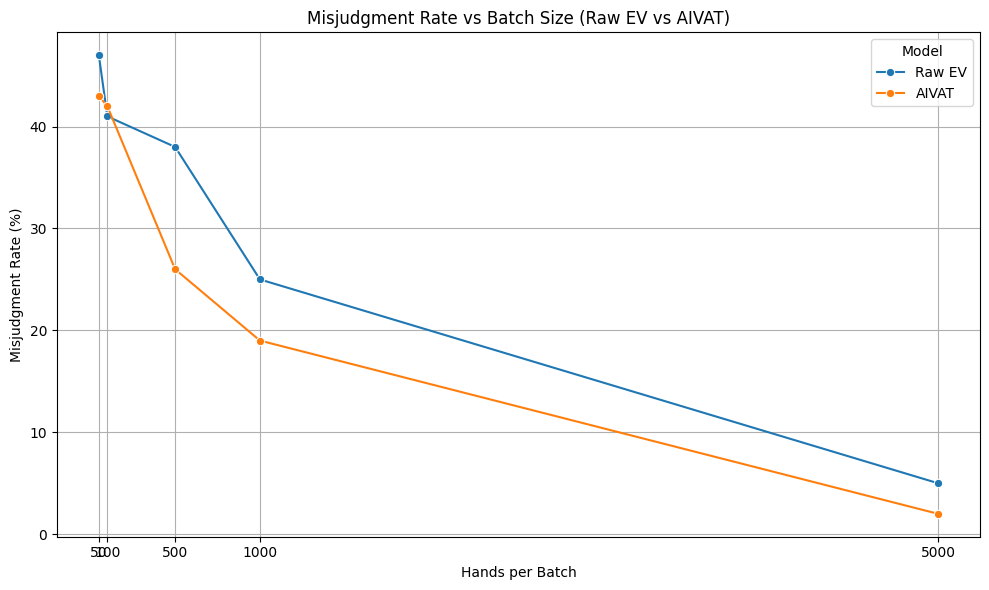

In [8]:
# Misjudgment Rate vs Sample Size (Curve)
sample_sizes = [50, 100, 500, 1000, 5000]
num_batches = 100
raw_results = []
aivat_results = []

for size in sample_sizes:
    raw_result = simulate_raw_ev_misjudge_rate(n_hands_per_batch=size, num_batches=num_batches)[0]
    raw_result["Model"] = "Raw EV"
    raw_results.append(raw_result)

    aivat_result = simulate_aivat_misjudge_rate(baseline_table, n_hands_per_batch=size, num_batches=num_batches)[0]
    aivat_result["Model"] = "AIVAT"
    aivat_results.append(aivat_result)

df_all = pd.DataFrame(raw_results + aivat_results)
df_plot = df_all[["Batch Size", "Model", "Misjudgment Rate"]].copy()
df_plot["Misjudgment Rate"] = df_plot["Misjudgment Rate"].str.replace("%", "").astype(float)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_plot, x="Batch Size", y="Misjudgment Rate", hue="Model", marker="o")
plt.title("Misjudgment Rate vs Batch Size (Raw EV vs AIVAT)")
plt.xlabel("Hands per Batch")
plt.ylabel("Misjudgment Rate (%)")
plt.grid(True)
plt.xticks(sample_sizes)
plt.tight_layout()
plt.show()

## ✅ Conclusion Summary

1. **Strategy B consistently outperforms Strategy A in long-run simulations.**  

2. **In small sample scenarios, Raw EV can occasionally have a lower misjudgment rate than AIVAT.**  

3. **While AIVAT may show higher misjudgment in very small samples, it quickly stabilizes and outperforms Raw EV as the sample size increases.**

4. **AIVAT effectively reduces variance and provides more consistent win-rate estimates.**  

5. **AIVAT achieves significant variance reduction in per-batch average EV.**  
   Based on 100 batches of 100 hands, the variance of Raw EV was `0.018106`, while AIVAT reduced it to `0.007569`.  
   An F-test confirmed that this difference is statistically significant (**p ≪ 0.05**, F = `2.392`), suggesting that the variance reduction is not due to random fluctuation.

---

These findings demonstrate that **AIVAT** is a reliable approach for improving estimation stability and reducing variance in small-sample poker strategy evaluation.
